
## Outline
1. **Setting up the Environment**: Installing necessary libraries and setting up paths.
2. **Creating Huggingface Dataset for Custom Dataset**: Understanding the structure and content of the dataset.

3. **Data Preprocessing**: Techniques to prepare the data for training, including handling different data splits and tokenization
4. **Training the Model**: Feeding data and adjusting weights.
5. **Inference**: Evaluate model on test set and making predictions.
6. **Experiment**: Experimenting with different tokenizer and models



# <font color = 'indianred'> **Setting up the Environment** </font>



In [1]:
 # CHANGE FOLDERS AS PER YOUR SETUP
from pathlib import Path
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    !pip install datasets transformers evaluate wandb accelerate seqeval -U -qq
    base_folder = Path("/content/drive/MyDrive/Colab_Notebooks/NLP")
else:
    base_folder = Path("/home/harpreet/Insync/google_drive_shaannoor/data")


from transformers import AutoConfig, AutoModelForTokenClassification, AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoTokenizer, DataCollatorForTokenClassification, pipeline
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel, Sequence
import evaluate


import wandb

import numpy as np
# from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import textwrap

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 85.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 116.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# CHANGE FOLDERS TO WHERE YOU WANT TO SAVE DATA AND MODELS
data_folder = base_folder/'Datasets'
model_folder = base_folder/'Models'
model_folder.mkdir(exist_ok=True)
data_folder.mkdir(exist_ok=True)

In [3]:
def print_wrap(text, d):
    # If the text is a list, convert it to a string
    if isinstance(text, list):
        # Convert None values to a default string (e.g., "None" or an empty string)
        text = ' '.join(str(item) if item is not None else "None" for item in text)

    # Wrap the text to limit the width to 'd'
    wrapped_text = textwrap.fill(text, width=d)

    # Print the wrapped text
    print(wrapped_text)


# <font color = 'indianred'> **Exploring and Understanding Dataset**

## <font color = 'indianred'> **conll2003 Dataset**</font>



## <font color = 'indianred'> **Load Data set**
    


In [4]:
conll_dataset = load_dataset('conll2003')

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

## <font color = 'indianred'> **Acess indivdual element** </font>


In [5]:
# get the first example of the dataset
conll_dataset['train'][0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

### <font color = 'indianred'> **Change dataset format to Pandas**  </font>


In [6]:
# Set the format to Pandas
conll_dataset.set_format(type='pandas')

In [7]:
# get all rows the dataset
df = conll_dataset['train'][:]

### <font color = 'indianred'> **Check length of the reviews** </font>


In [8]:
# Calculate words per review
df['words_per_sentence'] = df['tokens'].apply(len)

In [9]:
df.head()

,id,tokens,pos_tags,chunk_tags,ner_tags,words_per_sentence
0,0,"[EU, rejects, German, call, to, boycott, Briti...","[22, 42, 16, 21, 35, 37, 16, 21, 7]","[11, 21, 11, 12, 21, 22, 11, 12, 0]","[3, 0, 7, 0, 0, 0, 7, 0, 0]",9
1,1,"[Peter, Blackburn]","[22, 22]","[11, 12]","[1, 2]",2
2,2,"[BRUSSELS, 1996-08-22]","[22, 11]","[11, 12]","[5, 0]",2
3,3,"[The, European, Commission, said, on, Thursday...","[12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 3...","[11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 1...","[0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ...",30
4,4,"[Germany, 's, representative, to, the, Europea...","[22, 27, 21, 35, 12, 22, 22, 27, 16, 21, 22, 2...","[11, 11, 12, 13, 11, 12, 12, 11, 12, 12, 12, 1...","[5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ...",31


#### <font color = 'indianred'> **Plot the distribution of review length** </font>

In [10]:
# # Plot a histogram of the 'words_per_review' column
# df['words_per_sentence'].hist(bins=50, edgecolor='black')

# # Adding labels and a title for clarity
# plt.xlabel('Number of Words')
# plt.ylabel('Frequency')
# plt.title('Distribution of Words per Review')

# # Display the plot
# plt.show()


In [11]:
# The model we are going to use has token (subwords) limit of 512.
# Let us check how many reviews has more than 500 words

count = (df['words_per_sentence'] > 500).sum()
print(f"Number of reviews with more than 500 words: {count}")

Number of reviews with more than 500 words: 0


In [12]:
# check the rows that have one word
count = (df['words_per_sentence'] < 2).sum()
print(f"Number of reviews with less than 1 word: {count}")

Number of reviews with less than 1 word: 179


In [13]:
df[df['words_per_sentence'] < 2]

,id,tokens,pos_tags,chunk_tags,ner_tags,words_per_sentence
11,11,[.],[7],[0],[0],1
200,200,[THAWRA],[38],[11],[3],1
203,203,[IRAQ],[21],[11],[5],1
209,209,[AN-NAHAR],[22],[11],[3],1
212,212,[AS-SAFIR],[22],[11],[3],1
...,...,...,...,...,...,...
13751,13751,[Jul-18.Jul],[21],[11],[0],1
13855,13855,[GDP],[22],[11],[0],1
13879,13879,[ABC],[22],[11],[3],1
13883,13883,[EXPANSION],[21],[11],[3],1


### <font color = 'indianred'> **Reset dataset format** </font>


In [14]:
# reset the format back to huggingface dataset
conll_dataset.reset_format()

In [15]:
conll_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

# <font color = 'indianred'> **Data Pre-processing**</font>

In [16]:
train_split_small = conll_dataset['train'].shuffle(seed=42).select(range(5000))
val_split_small = conll_dataset['validation'].shuffle(seed=42).select(range(1000))
test_split_small = conll_dataset['test'].shuffle(seed=42).select(range(1000))

In [17]:
# combine train, val splits into one dataset
train_val_subset = DatasetDict({'train': train_split_small, 'val': val_split_small})

# create test dataset from test split
test_subset= DatasetDict({'test': test_split_small})

### <font color = 'indianred'> **Map Targets to integers** </font>

In [18]:
class_names = conll_dataset['train'].features['ner_tags'].feature.names

In [19]:
class_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

##  <font color = 'indianred'> **Experiment 1**

## <font color = 'indianred'> **Tokenization**</font>



In [20]:
# Define a checkpoint for the DistilBERT model with an uncased vocabulary.
# Instantiate the tokenizer for this model using the specified checkpoint.
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [21]:
idx = 0
encoded_text = tokenizer(train_val_subset['train']['tokens'][idx], is_split_into_words=True) ####### NEW ############
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)

###  <font color = 'indianred'> **Create function for Tokenizer**

In [22]:
def align_targets(labels, word_ids):

  begin2inside = {1:2, 3:4, 5:6, 7:8}
  aligned_labels = []

  last_id = None

  for word_id in word_ids:
    if word_id is None:
      label = -100
    elif word_id != last_id:
      label = labels[word_id]
    else:
      label = labels[word_id]
      if label in begin2inside:
        label = begin2inside[label]
    aligned_labels.append(label)
    last_id = word_id

  return aligned_labels

In [23]:
def tokenize_fn(batch):

  tokenized_inputs = tokenizer(batch['tokens'], truncation=True, is_split_into_words=True)

  # Extract the original labels/tags from the batch.
  labels_batch = batch['ner_tags']

  # This list will store the labels aligned with the tokenized input.
  aligned_labels_batch = []

  # Iterate over each example in the batch.
  for i, labels in enumerate(labels_batch):
    # Obtain the word IDs for the tokenized example. This helps in aligning the original labels with the tokens.
    word_ids = tokenized_inputs.word_ids(i)

    # Align the original labels with the tokenized example and append to the aligned_labels_batch list.
    aligned_labels_batch.append(align_targets(labels, word_ids))

  # The HuggingFace trainer expects the labels for token classification tasks to be under the key 'labels'.
  # Store the aligned labels in the 'labels' key of the tokenized_inputs dictionary.
  tokenized_inputs['labels'] = aligned_labels_batch

  return tokenized_inputs

###  <font color = 'indianred'> **Use map function to apply tokenization to all splits**

In [24]:
# Map the tokenize_fn function over the entire train_val_subset dataset in batches.
# This will tokenize the text data in each batch and return a new dataset with tokenized data.
tokenized_dataset = train_val_subset.map(tokenize_fn, batched=True)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [25]:
tokenized_dataset['train']

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 5000
})

In [26]:
tokenized_dataset = tokenized_dataset.remove_columns(['tokens', 'ner_tags', 'pos_tags','chunk_tags', 'id'])
tokenized_dataset.set_format(type='torch')

#  <font color = 'indianred'> **Model Training**

In [27]:
def initialize_model(checkpoint, class_names):
    config = AutoConfig.from_pretrained(checkpoint)
    id2label = {}
    for id_, label_ in enumerate(class_names):
        id2label[str(id_)] = label_

    label2id = {}
    for id_, label_ in enumerate(class_names):
        label2id[label_] = id_

    config.id2label = id2label
    config.label2id = label2id

    model = AutoModelForTokenClassification.from_pretrained(checkpoint, config=config)
    return model

In [28]:
model = initialize_model(checkpoint, class_names)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
model.config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "O",
    "1": "B-PER",
    "2": "I-PER",
    "3": "B-ORG",
    "4": "I-ORG",
    "5": "B-LOC",
    "6": "I-LOC",
    "7": "B-MISC",
    "8": "I-MISC"
  },
  "initializer_range": 0.02,
  "label2id": {
    "B-LOC": 5,
    "B-MISC": 7,
    "B-ORG": 3,
    "B-PER": 1,
    "I-LOC": 6,
    "I-MISC": 8,
    "I-ORG": 4,
    "I-PER": 2,
    "O": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.34.1",
  "vocab_size": 30522
}

## <font color = 'indianred'> **Model Input/Collate Function** </font>

In [30]:
data_collator = DataCollatorForTokenClassification(tokenizer = tokenizer, padding=True, label_pad_token_id=-100, return_tensors='pt')
features = [tokenized_dataset["train"][i] for i in range(2)]
model_input = data_collator(features)
model_input.keys()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


dict_keys(['input_ids', 'attention_mask', 'labels'])

##  <font color = 'indianred'> **Evaluation metric(s)** </font>

### <font color = 'indianred'> **Function to compute metric** </font>



In [31]:
seqeval_metric = evaluate.load('seqeval')

def compute_metrics(logits_and_labels):

    logits, true_labels = logits_and_labels

    # Obtain predicted label indices by selecting the label with the highest logit value for each token
    predicted_indices = np.argmax(logits, axis=-1)  # Shape: (batch_size, sequence_length)

    # Convert label indices to their string representation, ignoring special tokens (label index = -100)
    string_true_labels = [[class_names[label_id] for label_id in sequence if label_id != -100] for sequence in true_labels]

    # for pred_sequence, true_sequence in zip(predicted_indices, true_labels):
    #   for pred_id, true_label_id in zip(pred_sequence, true_sequence):
    #     if true_label_id != -100:
    #       print(class_names[pred_id])

    # Convert predicted indices to their string representation, but only for tokens where the true label isn't -100
    string_predictions = [[class_names[pred_id] for pred_id, true_label_id in zip(pred_sequence, true_sequence) if true_label_id != -100]
        for pred_sequence, true_sequence in zip(predicted_indices, true_labels)]


    # print('Length of predicted_indices = ', len(predicted_indices))
    # print('Length of predicted_indices = ', len(true_labels))

    # Compute the metrics using seqeval
    metrics_results = seqeval_metric.compute(predictions=string_predictions, references=string_true_labels)

    return {
        'precision': metrics_results['overall_precision'],
        'recall': metrics_results['overall_recall'],
        'f1': metrics_results['overall_f1'],
        'accuracy': metrics_results['overall_accuracy']
    }

In [32]:
# compute_metrics((logits, true_labels))

## <font color = 'indianred'> **Set up Logger for experiments**</font>

In [33]:
# YOU WILL NEED TO CREATE AN ACCOUNT FOR WANDB
# It may provide a link for token , copy paste the token following instructions
# setup wandb
wandb.login()  # you will need to create wandb account first
# Set project name for logging
%env WANDB_PROJECT = nlp_course_fall_2023-ner

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


env: WANDB_PROJECT=nlp_course_fall_2023-ner


## <font color = 'indianred'> **Hyperparameters and Checkpointing**</font>

In [34]:
# Define the directory where model checkpoints will be saved
model_folder = base_folder / "Models"
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size = 64,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size = 64,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=40,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps= 40,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="accuracy",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=40,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= 'ner_exp1',  # Experiment name for Weights & Biases
)


##  <font color = 'indianred'> **Initialize Trainer**</font>

In [35]:
# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)


##  <font color = 'indianred'> **Start Training**

In [36]:
trainer.data_collator

DataCollatorForTokenClassification(tokenizer=DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}, padding=True, max_length=None, pad_to_multiple_of=None, label_pad_tok

In [37]:
trainer.train()  # start training

wandb: Currently logged in as: shremuk. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
40,0.980100,0.500629,0.437956,0.167224,0.242033,0.846903
80,0.402900,0.286862,0.571865,0.625418,0.597444,0.921373
120,0.251900,0.201444,0.619949,0.675585,0.646572,0.939898


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=158, training_loss=0.46707990501500385, metrics={'train_runtime': 67.3122, 'train_samples_per_second': 148.561, 'train_steps_per_second': 2.347, 'total_flos': 147454559772912.0, 'train_loss': 0.46707990501500385, 'epoch': 2.0})

## <font color = 'indianred'> **Evaluation**


### <font color = 'indianred'> **Check performance on validation set**</font>


In [38]:
# Evaluate the trained model on the tokenized validation dataset.
# This will provide metrics like loss, accuracy, etc. based on the model's performance on the validation set.
trainer.evaluate(tokenized_dataset["val"])

{'eval_loss': 0.20144402980804443,
 'eval_precision': 0.6199488491048594,
 'eval_recall': 0.6755852842809364,
 'eval_f1': 0.6465724193118165,
 'eval_accuracy': 0.9398979001105205,
 'eval_runtime': 2.8831,
 'eval_samples_per_second': 346.853,
 'eval_steps_per_second': 5.55,
 'epoch': 2.0}

###  <font color = 'indianred'> **Check Confusion Matrix**</font>




In [39]:
# Use the trainer to generate predictions on the tokenized validation dataset.
# The resulting object, valid_output, will contain the model's logits (raw prediction scores) for each input in the validation set.
valid_output = trainer.predict(tokenized_dataset["val"])
valid_predictions = np.argmax(valid_output.predictions, axis=2)
valid_labels = np.array(valid_output.label_ids)
mask = valid_labels != -100
filtered_predictions = valid_predictions[mask]
filtered_labels = valid_labels[mask]

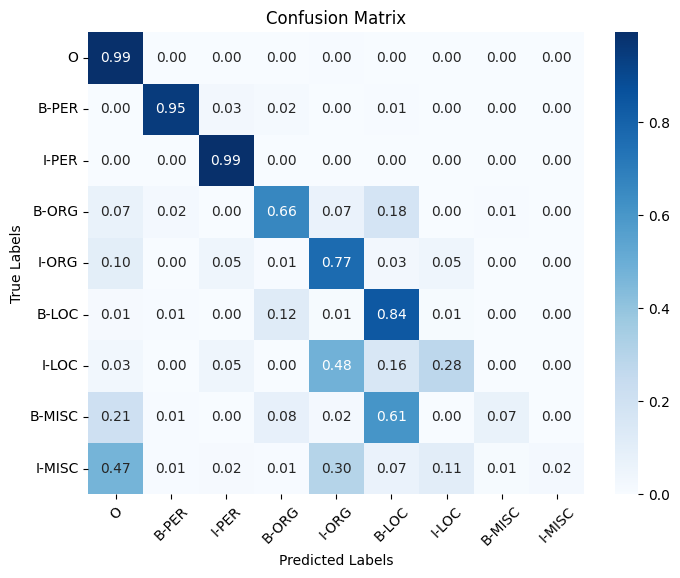

In [40]:
#  Generate the confusion matrix
cm = confusion_matrix(filtered_labels, filtered_predictions,normalize='true')

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
ax= sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
# Ensure x-labels are vertical
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Ensure y-labels are horizontal
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [41]:
# Log the confusion matrix to the Weights & Biases (Wandb) platform for monitoring and visualization.
# This allows for tracking the model's classification performance across different runs or iterations.

# log the Confusion Matrix to Wandb
wandb.log({
    "conf_mat": wandb.plot.confusion_matrix(
        preds=filtered_predictions,        # Model's predicted class labels.
        y_true=filtered_labels,      # Actual labels from the validation set.
        class_names=class_names   # Custom class names for display in the confusion matrix.
    )
})

In [42]:
wandb.finish()

eval/accuracy,▁▇██
eval/f1,▁▇██
eval/loss,█▃▁▁
eval/precision,▁▆██
eval/recall,▁▇██
eval/runtime,▁▅▆█
eval/samples_per_second,█▃▃▁
eval/steps_per_second,█▃▃▁
train/epoch,▁▁▃▃▆▆██
train/global_step,▁▁▃▃▆▆███
train/learning_rate,█▅▁


### <font color = 'indianred'> **Check the best saved model**</font>


In [43]:
# After training, let us check the best checkpoint
# We need this for Predictions and Evaluations
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 120.


#  <font color = 'indianred'> **Inference**

##  <font color = 'indianred'> **Pipeline for Predictions**

## <font color = 'indianred'> **Create pipelne for inference**

In [44]:
checkpoint = str(model_folder / "checkpoint-120")
checkpoint
# Create a text classification pipeline using the Hugging Face's pipeline method.
# The pipeline is initialized with:
# - The task set to "text-classification".
# - Model and tokenizer both loaded from the specified checkpoint path.
# - Execution set to the primary device (typically the first GPU).

custom_pipeline = pipeline(
    task="token-classification",
    model=checkpoint,
    tokenizer=checkpoint,
    device='cpu',
    aggregation_strategy="simple",
    framework="pt")


## <font color = 'indianred'> **Prediction for large dataset**

In [45]:
def preprocess_for_pipeline(example):
    return {"processed_text": " ".join(example['tokens'])}

test_subset['test'] = test_subset['test'].map(preprocess_for_pipeline)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [47]:
custom_pipeline = pipeline(
    task="token-classification",
    model=checkpoint,
    tokenizer=checkpoint,
    device=0,
    aggregation_strategy="simple",
    framework="pt")

predictions = custom_pipeline(test_subset['test']['processed_text'], batch_size=16)

In [48]:
predictions[0]

[{'entity_group': 'ORG',
  'score': 0.57524335,
  'word': 'hartford',
  'start': 0,
  'end': 8},
 {'entity_group': 'ORG',
  'score': 0.5366765,
  'word': 'boston',
  'start': 11,
  'end': 17}]

##  <font color = 'indianred'> **Test Set Evaluations**

In [50]:
test_subset_tokenized = test_subset.map(tokenize_fn, batched=True)
test_subset_tokenized = test_subset_tokenized.remove_columns(['tokens', 'ner_tags', 'pos_tags','chunk_tags', 'id', 'processed_text'])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [52]:
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# model = AutoModelForTokenClassification.from_pretrained(checkpoint)

training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size = 32,  # adjust based on your GPU memory
    do_train = False,
    do_eval=True,
    report_to=[]  # disable logging
)

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_subset_tokenized['test'],  # Make sure this dataset is tokenized!
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

results = trainer.evaluate()

In [53]:
results

{'eval_loss': 0.22334277629852295,
 'eval_precision': 0.6321014892443464,
 'eval_recall': 0.7004889975550123,
 'eval_f1': 0.6645404465062337,
 'eval_accuracy': 0.9370192307692308,
 'eval_runtime': 2.3326,
 'eval_samples_per_second': 428.701,
 'eval_steps_per_second': 13.718}

# **Experiment 2**

## <font color = 'indianred'> **Tokenization**</font>



In [54]:
# Define a checkpoint for the DistilBERT model with an uncased vocabulary.
# Instantiate the tokenizer for this model using the specified checkpoint.
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [55]:
idx = 0
encoded_text = tokenizer(train_val_subset['train']['tokens'][idx], is_split_into_words=True) ####### NEW ############
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)

###  <font color = 'indianred'> **Use map function to apply tokenization to all splits**

In [56]:
# Map the tokenize_fn function over the entire train_val_subset dataset in batches.
# This will tokenize the text data in each batch and return a new dataset with tokenized data.
tokenized_dataset_bert = train_val_subset.map(tokenize_fn, batched=True)
tokenized_dataset_bert = tokenized_dataset_bert.remove_columns(['tokens', 'ner_tags', 'pos_tags','chunk_tags', 'id'])
tokenized_dataset_bert.set_format(type='torch')

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

#  <font color = 'indianred'> **Model Training**

In [59]:
model = initialize_model(checkpoint, class_names)
model.config

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## <font color = 'indianred'> **Model Input/Collate Function** </font>

In [61]:
data_collator = DataCollatorForTokenClassification(tokenizer = tokenizer, padding=True, label_pad_token_id=-100, return_tensors='pt')
features = [tokenized_dataset_bert["train"][i] for i in range(2)]
model_input = data_collator(features)
model_input.keys()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

## <font color = 'indianred'> **Set up Logger for experiments**</font>

In [ ]:
# # YOU WILL NEED TO CREATE AN ACCOUNT FOR WANDB
# # It may provide a link for token , copy paste the token following instructions
# # setup wandb
# wandb.init()
# wandb.login()  # you will need to create wandb account first
# # Set project name for logging
# %env WANDB_PROJECT = nlp_course_fall_2023-ner

wandb: Currently logged in as: shremuk. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


env: WANDB_PROJECT=nlp_course_fall_2023-ner


## <font color = 'indianred'> **Hyperparameters and Checkpointing**</font>

In [62]:
# Define the directory where model checkpoints will be saved
model_folder = base_folder/"Models"
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size = 32,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size = 32,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="accuracy",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= 'ner_exp1',  # Experiment name for Weights & Biases
)


##  <font color = 'indianred'> **Initialize Trainer**</font>

In [65]:
# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_bert["train"],
    eval_dataset=tokenized_dataset_bert["val"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

##  <font color = 'indianred'> **Start Training**

In [64]:
trainer.data_collator

DataCollatorForTokenClassification(tokenizer=BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}, padding=True, max_length=None, pad_to_multiple_of=None, label_pad_token_id=-100, 

In [66]:
trainer.train()  # start training

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,1.233400,0.702966,0.000000,0.000000,0.000000,0.792906
40,0.562000,0.384860,0.492785,0.513935,0.503138,0.882848
60,0.350300,0.277799,0.532175,0.631550,0.577619,0.918004
80,0.307200,0.215132,0.606030,0.661093,0.632365,0.938530
100,0.229300,0.163050,0.690853,0.753623,0.720874,0.955213
120,0.187000,0.131130,0.765041,0.822185,0.792585,0.966002
140,0.175500,0.118504,0.771443,0.837235,0.802994,0.967212
160,0.132000,0.103592,0.809474,0.857302,0.832702,0.971949
180,0.113500,0.101845,0.797828,0.860089,0.827790,0.970791
200,0.105700,0.092961,0.823374,0.867893,0.845047,0.973949


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are i

TrainOutput(global_step=314, training_loss=0.2525514144047051, metrics={'train_runtime': 300.7344, 'train_samples_per_second': 33.252, 'train_steps_per_second': 1.044, 'total_flos': 266788623410928.0, 'train_loss': 0.2525514144047051, 'epoch': 2.0})

## <font color = 'indianred'> **Evaluation**


### <font color = 'indianred'> **Check performance on validation set**</font>


In [69]:
# Evaluate the trained model on the tokenized validation dataset.
# This will provide metrics like loss, accuracy, etc. based on the model's performance on the validation set.
trainer.evaluate(tokenized_dataset_bert["val"])

{'eval_loss': 0.08483275771141052,
 'eval_precision': 0.8432835820895522,
 'eval_recall': 0.8818283166109253,
 'eval_f1': 0.862125340599455,
 'eval_accuracy': 0.9761065207094364,
 'eval_runtime': 6.2869,
 'eval_samples_per_second': 159.06,
 'eval_steps_per_second': 5.09,
 'epoch': 2.0}

###  <font color = 'indianred'> **Check Confusion Matrix**</font>




In [70]:
# Use the trainer to generate predictions on the tokenized validation dataset.
# The resulting object, valid_output, will contain the model's logits (raw prediction scores) for each input in the validation set.
valid_output = trainer.predict(tokenized_dataset_bert["val"])
valid_predictions = np.argmax(valid_output.predictions, axis=2)
valid_labels = np.array(valid_output.label_ids)
mask = valid_labels != -100
filtered_predictions = valid_predictions[mask]
filtered_labels = valid_labels[mask]

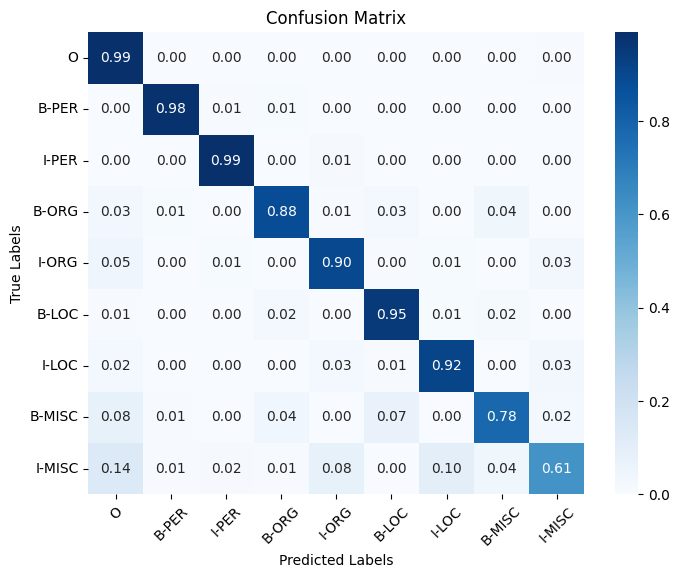

In [71]:
#  Generate the confusion matrix
cm = confusion_matrix(filtered_labels, filtered_predictions,normalize='true')

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
ax= sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
# Ensure x-labels are vertical
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Ensure y-labels are horizontal
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [72]:
# Log the confusion matrix to the Weights & Biases (Wandb) platform for monitoring and visualization.
# This allows for tracking the model's classification performance across different runs or iterations.

# log the Confusion Matrix to Wandb
wandb.log({
    "conf_mat": wandb.plot.confusion_matrix(
        preds=filtered_predictions,        # Model's predicted class labels.
        y_true=filtered_labels,      # Actual labels from the validation set.
        class_names=class_names   # Custom class names for display in the confusion matrix.
    )
})

In [73]:
wandb.finish()

eval/accuracy,▁▄▆▇▇████████████
eval/f1,▁▅▆▆▇▇███████████
eval/loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
eval/precision,▁▅▅▆▇▇▇██████████
eval/recall,▁▅▆▆▇████████████
eval/runtime,▂▄▂▄▂▂▁▁▂▃▁▄▂▂▁▁█
eval/samples_per_second,▆▅▆▄▇▆██▆▅█▄▆▆██▁
eval/steps_per_second,▆▅▆▄▇▆██▆▅█▄▆▆██▁
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██████
train/learning_rate,██▇▇▆▆▅▅▄▄▃▃▂▂▁


### <font color = 'indianred'> **Check the best saved model**</font>


In [74]:
# After training, let us check the best checkpoint
# We need this for Predictions and Evaluations
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 280.


#  <font color = 'indianred'> **Inference**

##  <font color = 'indianred'> **Pipeline for Predictions**

## <font color = 'indianred'> **Create pipelne for inference**

In [75]:
checkpoint = str(model_folder / "checkpoint-280")
checkpoint
# Create a text classification pipeline using the Hugging Face's pipeline method.
# The pipeline is initialized with:
# - The task set to "text-classification".
# - Model and tokenizer both loaded from the specified checkpoint path.
# - Execution set to the primary device (typically the first GPU).

custom_pipeline = pipeline(
    task="token-classification",
    model=checkpoint,
    tokenizer=checkpoint,
    device='cpu',
    aggregation_strategy="simple",
    framework="pt")

## <font color = 'indianred'> **Prediction for large dataset**

In [76]:
test_subset['test'] = test_subset['test'].map(preprocess_for_pipeline)
predictions = custom_pipeline(test_subset['test']['processed_text'], batch_size=16)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [77]:
# custom_pipeline = pipeline(
#     task="token-classification",
#     model=checkpoint,
#     tokenizer=checkpoint,
#     device=0,
#     aggregation_strategy="simple",
#     framework="pt")

In [78]:
predictions[0]

[{'entity_group': 'ORG',
  'score': 0.9816835,
  'word': 'hartford',
  'start': 0,
  'end': 8},
 {'entity_group': 'ORG',
  'score': 0.98009765,
  'word': 'boston',
  'start': 11,
  'end': 17}]

##  <font color = 'indianred'> **Test Set Evaluations**

In [81]:
test_subset_tokenized = test_subset.map(tokenize_fn, batched=True)
test_subset_tokenized = test_subset_tokenized.remove_columns(['tokens', 'ner_tags', 'pos_tags','chunk_tags', 'id', 'processed_text'])

In [83]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size = 32,  # adjust based on your GPU memory
    do_train = False,
    do_eval=True,
    report_to=[]  # disable logging
)

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_subset_tokenized['test'],  # Make sure this dataset is tokenized!
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

results = trainer.evaluate()

In [84]:
results

{'eval_loss': 0.12346488982439041,
 'eval_precision': 0.7945976364659538,
 'eval_recall': 0.863080684596577,
 'eval_f1': 0.8274245531790214,
 'eval_accuracy': 0.963701923076923,
 'eval_runtime': 4.1399,
 'eval_samples_per_second': 241.55,
 'eval_steps_per_second': 7.73}

# **Experiment 3**

In [87]:
# Define a checkpoint for the DistilBERT model with an uncased vocabulary.
# Instantiate the tokenizer for this model using the specified checkpoint.
checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, add_prefix_space=True)

In [88]:
idx = 0
encoded_text = tokenizer(train_val_subset['train']['tokens'][idx], is_split_into_words=True) ####### NEW ############
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)

###  <font color = 'indianred'> **Use map function to apply tokenization to all splits**

In [89]:
# Map the tokenize_fn function over the entire train_val_subset dataset in batches.
# This will tokenize the text data in each batch and return a new dataset with tokenized data.
tokenized_dataset_roberta = train_val_subset.map(tokenize_fn, batched=True)
tokenized_dataset_roberta = tokenized_dataset_roberta.remove_columns(['tokens', 'ner_tags', 'pos_tags','chunk_tags', 'id'])
tokenized_dataset_roberta.set_format(type='torch')

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

#  <font color = 'indianred'> **Model Training**

In [90]:
model = initialize_model(checkpoint, class_names)
model.config

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-PER",
    "2": "I-PER",
    "3": "B-ORG",
    "4": "I-ORG",
    "5": "B-LOC",
    "6": "I-LOC",
    "7": "B-MISC",
    "8": "I-MISC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 5,
    "B-MISC": 7,
    "B-ORG": 3,
    "B-PER": 1,
    "I-LOC": 6,
    "I-MISC": 8,
    "I-ORG": 4,
    "I-PER": 2,
    "O": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.34.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

## <font color = 'indianred'> **Model Input/Collate Function** </font>

In [91]:
data_collator = DataCollatorForTokenClassification(tokenizer = tokenizer, padding=True, label_pad_token_id=-100, return_tensors='pt')
features = [tokenized_dataset_roberta["train"][i] for i in range(2)]
model_input = data_collator(features)
model_input.keys()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


dict_keys(['input_ids', 'attention_mask', 'labels'])

## <font color = 'indianred'> **Hyperparameters and Checkpointing**</font>

In [92]:
# Define the directory where model checkpoints will be saved
model_folder = base_folder/"Models"
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size = 32,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size = 32,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="accuracy",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= 'ner_exp1',  # Experiment name for Weights & Biases
)


##  <font color = 'indianred'> **Initialize Trainer**</font>

In [93]:
# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= tokenized_dataset_roberta["train"],
    eval_dataset= tokenized_dataset_roberta["val"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

##  <font color = 'indianred'> **Start Training**

In [94]:
trainer.data_collator

DataCollatorForTokenClassification(tokenizer=RobertaTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}, padding=True, max_length=None, pad_to_multiple_of=None, l

In [95]:
trainer.train()  # start training

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,1.222300,0.626801,0.000000,0.000000,0.000000,0.771951
40,0.514000,0.364500,0.444653,0.528428,0.482934,0.891403
60,0.324500,0.242401,0.544046,0.626533,0.582383,0.924578
80,0.245500,0.165264,0.626122,0.700111,0.661053,0.943994
100,0.185200,0.139506,0.730809,0.795987,0.762006,0.959639
120,0.157400,0.118704,0.773546,0.837793,0.804389,0.965754
140,0.155500,0.105053,0.828933,0.875139,0.851410,0.971309
160,0.120500,0.089093,0.839937,0.886288,0.862490,0.975437
180,0.093700,0.085790,0.861976,0.894649,0.878009,0.975539
200,0.096200,0.079180,0.872168,0.901338,0.886513,0.977679


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=314, training_loss=0.2321999407118293, metrics={'train_runtime': 379.519, 'train_samples_per_second': 26.349, 'train_steps_per_second': 0.827, 'total_flos': 267437823624000.0, 'train_loss': 0.2321999407118293, 'epoch': 2.0})

## <font color = 'indianred'> **Evaluation**


### <font color = 'indianred'> **Check performance on validation set**</font>


In [96]:
# Evaluate the trained model on the tokenized validation dataset.
# This will provide metrics like loss, accuracy, etc. based on the model's performance on the validation set.
trainer.evaluate(tokenized_dataset_roberta["val"])

{'eval_loss': 0.07382317632436752,
 'eval_precision': 0.8739989321943407,
 'eval_recall': 0.9124860646599777,
 'eval_f1': 0.8928279247341152,
 'eval_accuracy': 0.9804820873464811,
 'eval_runtime': 4.1555,
 'eval_samples_per_second': 240.645,
 'eval_steps_per_second': 7.701,
 'epoch': 2.0}

###  <font color = 'indianred'> **Check Confusion Matrix**</font>




In [97]:
# Use the trainer to generate predictions on the tokenized validation dataset.
# The resulting object, valid_output, will contain the model's logits (raw prediction scores) for each input in the validation set.
valid_output = trainer.predict(tokenized_dataset_roberta["val"])
valid_predictions = np.argmax(valid_output.predictions, axis=2)
valid_labels = np.array(valid_output.label_ids)
mask = valid_labels != -100
filtered_predictions = valid_predictions[mask]
filtered_labels = valid_labels[mask]

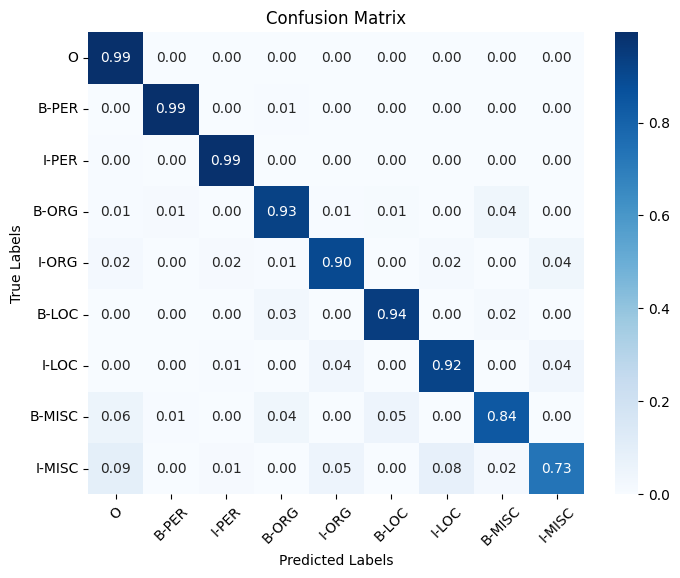

In [98]:
#  Generate the confusion matrix
cm = confusion_matrix(filtered_labels, filtered_predictions,normalize='true')

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
ax= sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
# Ensure x-labels are vertical
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Ensure y-labels are horizontal
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [99]:
# Log the confusion matrix to the Weights & Biases (Wandb) platform for monitoring and visualization.
# This allows for tracking the model's classification performance across different runs or iterations.

# log the Confusion Matrix to Wandb
wandb.log({
    "conf_mat": wandb.plot.confusion_matrix(
        preds=filtered_predictions,        # Model's predicted class labels.
        y_true=filtered_labels,      # Actual labels from the validation set.
        class_names=class_names   # Custom class names for display in the confusion matrix.
    )
})

In [100]:
wandb.finish()

eval/accuracy,▁▅▆▇▇███████████
eval/f1,▁▅▆▆▇▇██████████
eval/loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁
eval/precision,▁▅▅▆▇▇██████████
eval/recall,▁▅▆▆▇▇██████████
eval/runtime,▂▄▂▂█▄▂▆▂▁▂▂▂▆▅▃
eval/samples_per_second,▇▅▇▇▁▄▇▃▆█▇▆▇▂▃▆
eval/steps_per_second,▇▅▇▇▁▄▇▃▆█▇▆▇▂▃▆
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█████
train/learning_rate,██▇▇▆▆▅▅▄▄▃▃▂▂▁


### <font color = 'indianred'> **Check the best saved model**</font>


In [101]:
# After training, let us check the best checkpoint
# We need this for Predictions and Evaluations
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 240.


#  <font color = 'indianred'> **Inference**

##  <font color = 'indianred'> **Pipeline for Predictions**

## <font color = 'indianred'> **Create pipelne for inference**

In [102]:
checkpoint = str(model_folder / "checkpoint-240")
checkpoint
# Create a text classification pipeline using the Hugging Face's pipeline method.
# The pipeline is initialized with:
# - The task set to "text-classification".
# - Model and tokenizer both loaded from the specified checkpoint path.
# - Execution set to the primary device (typically the first GPU).

custom_pipeline = pipeline(
    task="token-classification",
    model=checkpoint,
    tokenizer=checkpoint,
    device='cpu',
    aggregation_strategy="simple",
    framework="pt")

## <font color = 'indianred'> **Prediction for large dataset**

In [103]:
test_subset['test'] = test_subset['test'].map(preprocess_for_pipeline)
predictions = custom_pipeline(test_subset['test']['processed_text'], batch_size=16)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# custom_pipeline = pipeline(
#     task="token-classification",
#     model=checkpoint,
#     tokenizer=checkpoint,
#     device=0,
#     aggregation_strategy="simple",
#     framework="pt")

In [104]:
predictions[0]

[{'entity_group': 'ORG',
  'score': 0.98335636,
  'word': ' Hartford',
  'start': 0,
  'end': 8},
 {'entity_group': 'ORG',
  'score': 0.98337317,
  'word': ' BOSTON',
  'start': 11,
  'end': 17}]

##  <font color = 'indianred'> **Test Set Evaluations**

In [105]:
test_subset_tokenized = test_subset.map(tokenize_fn, batched=True)
test_subset_tokenized = test_subset_tokenized.remove_columns(['tokens', 'ner_tags', 'pos_tags','chunk_tags', 'id', 'processed_text'])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [106]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size = 32,  # adjust based on your GPU memory
    do_train = False,
    do_eval=True,
    report_to=[]  # disable logging
)

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_subset_tokenized['test'],  # Make sure this dataset is tokenized!
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

results = trainer.evaluate()

In [107]:
results

{'eval_loss': 0.11647728085517883,
 'eval_precision': 0.8369690011481056,
 'eval_recall': 0.89119804400978,
 'eval_f1': 0.8632326820603908,
 'eval_accuracy': 0.9686763607103857,
 'eval_runtime': 3.0747,
 'eval_samples_per_second': 325.231,
 'eval_steps_per_second': 10.407}

## **Conclusion**
I'd go ahead with **RobertaTokenizer** since it has given the highest f1 score of **86.32%** and considerably good accuracy of **96.86%**.